In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os

In [2]:
file_id = '1Fo4swaHNL7XW4xQ72It7Hf7L2UmtmbCg'
dataset_link = f'https://drive.google.com/uc?id={file_id}'
output_file = 'dataset.zip'

In [3]:
if not os.path.exists(output_file):
    gdown.download(dataset_link, output_file, quiet=False)
    print(f"Файл {output_file} скачан.")
else:
    print(f"Файл {output_file} уже существует.")

Файл dataset.zip уже существует.


In [4]:
df = pd.read_csv(output_file, compression='zip')

Посмотрим на пример данных

In [5]:
df.head(2)

,Game_ID,Rated,Variant,Speed,Created_At,Last_Move_At,Game_Status,Source,Winner,Opening_Name,...,Black_Inaccuracy,Black_Mistake,Black_Blunder,Black_ACPL,Clocks,Analysis,Total_Time_Init,Total_Time_Increment,Total_Time,Moves
0,PsevV6VH,True,standard,classical,2024-12-15T11:09:25.224000+00:00,2024-12-15T11:55:14.775000+00:00,resign,pool,white,English Opening: Symmetrical Variation,...,5,1,1,47,"[180003, 180003, 178499, 178019, 178339, 17757...","[{'eval': 14}, {'eval': 25}, {'eval': 26}, {'e...",1800,0,1800,Nf3 c5 c4 Nc6 Nc3 g6 e3 Bg7 d4 cxd4 exd4 d6 h3...
1,diLZa8sj,True,standard,classical,2024-10-28T13:54:16.605000+00:00,2024-10-28T14:32:21.403000+00:00,resign,pool,white,"French Defense: Winawer Variation, Advance Var...",...,4,0,1,31,"[180003, 180003, 179827, 179683, 178619, 17936...","[{'eval': 18}, {'eval': 28}, {'eval': 28}, {'e...",1800,0,1800,e4 e6 d4 d5 Nc3 Bb4 e5 Ne7 a3 Bxc3+ bxc3 b6 Bb...


Определим колонки, которые нужны для EDA анализа

In [6]:
columns_for_eda = [
    'Created_At', 'Last_Move_At', 'Total_Time_Init',
    'Total_Time_Increment', 'Total_Time', 'White_ACPL',
    'Black_ACPL', 'Moves'
]

Оставим в датасете только колонки для EDA

In [7]:
df_filtered = df.filter(items=columns_for_eda)

Проверим на наличие пропусков

In [8]:
df_filtered.isna().sum()

Created_At              0
Last_Move_At            0
Total_Time_Init         0
Total_Time_Increment    0
Total_Time              0
White_ACPL              0
Black_ACPL              0
Moves                   0
dtype: int64

Можно сделать вывод, что пропусков нет.

Проверим типы данных и приведем их к нужному виду

In [9]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140792 entries, 0 to 140791
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Created_At            140792 non-null  object
 1   Last_Move_At          140792 non-null  object
 2   Total_Time_Init       140792 non-null  int64 
 3   Total_Time_Increment  140792 non-null  int64 
 4   Total_Time            140792 non-null  int64 
 5   White_ACPL            140792 non-null  int64 
 6   Black_ACPL            140792 non-null  int64 
 7   Moves                 140792 non-null  object
dtypes: int64(5), object(3)
memory usage: 8.6+ MB


In [10]:
df_filtered['Created_At'] = (
    pd.to_datetime(df_filtered['Created_At'], format='ISO8601')
    .dt.tz_localize(None)
    .dt.floor('s')
)

In [11]:
df_filtered['Last_Move_At'] = (
    pd.to_datetime(df_filtered['Last_Move_At'], format='ISO8601')
    .dt.tz_localize(None)
    .dt.floor('s')
)

Выведем описательную статистику

In [12]:
df_filtered.describe().T

,count,mean,min,25%,50%,75%,max,std
Created_At,140792,2024-05-12 18:56:09.904682240,2014-12-08 15:14:10,2024-03-25 04:49:06.750000128,2024-10-05 10:17:08.500000,2024-12-28 19:07:25,2025-02-05 08:53:27,NaN
Last_Move_At,140792,2024-05-12 19:08:54.211830528,2014-12-08 15:42:30,2024-03-25 04:51:24,2024-10-05 10:19:55.500000,2024-12-28 19:18:18,2025-02-05 09:04:38,NaN
Total_Time_Init,140792.0,540.550599,0.0,60.0,180.0,600.0,10800.0,710.17768
Total_Time_Increment,140792.0,2.675152,0.0,0.0,0.0,0.0,180.0,7.882592
Total_Time,140792.0,647.556679,15.0,60.0,180.0,600.0,18000.0,924.347914
White_ACPL,140792.0,39.942291,0.0,21.0,34.0,50.0,1307.0,29.264111
Black_ACPL,140792.0,41.485738,0.0,22.0,36.0,52.0,1337.0,30.132168


На первый взгляд неверных значений не наблюдаем.

Посмотрим на переменную `Created_At` и ее распределение

In [13]:
df_filtered['Created_Year'] = df_filtered['Created_At'].dt.to_period('Y')

year_counts = df_filtered.groupby('Created_Year').size()
year_counts

Created_Year
2014        1
2015       16
2016        7
2017      354
2018      576
2019      512
2020     1930
2021     3627
2022     5146
2023    15441
2024    79974
2025    33208
Freq: Y-DEC, dtype: int64

Удалим данные с 2014 по 2019 годы из-за малого числа наблюдений

In [14]:
df_filtered = df_filtered[~df_filtered['Created_Year'].astype(
    str).isin(['2014', '2015', '2016', '2017', '2018', '2019'])]

Построим корреляционную матрицу переменных

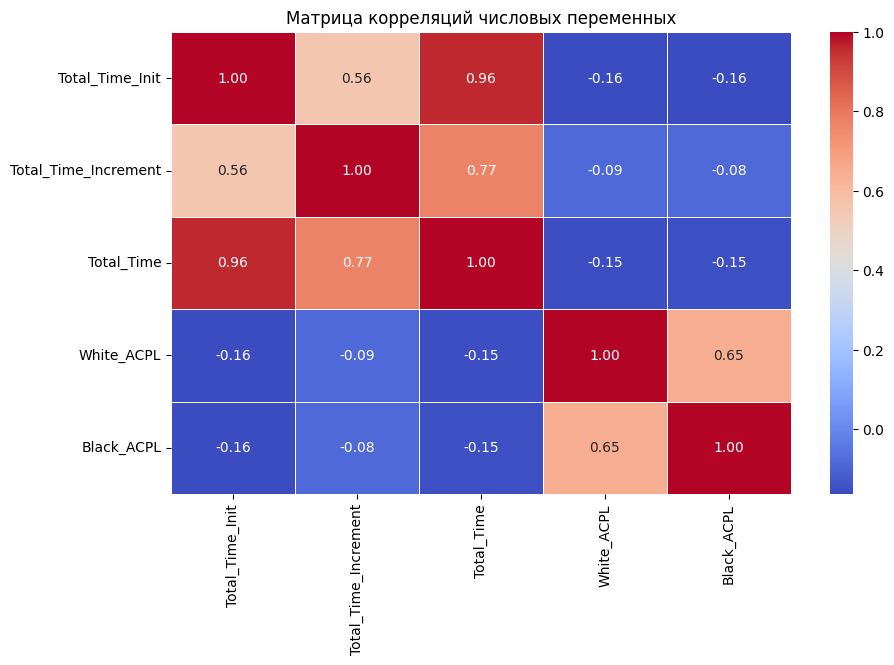

In [15]:
correlation_matrix = df_filtered.filter(items=columns_for_eda).select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляций числовых переменных")
plt.show()

Построим визуалиазации для исследуемых переменных

#### Временные ряды

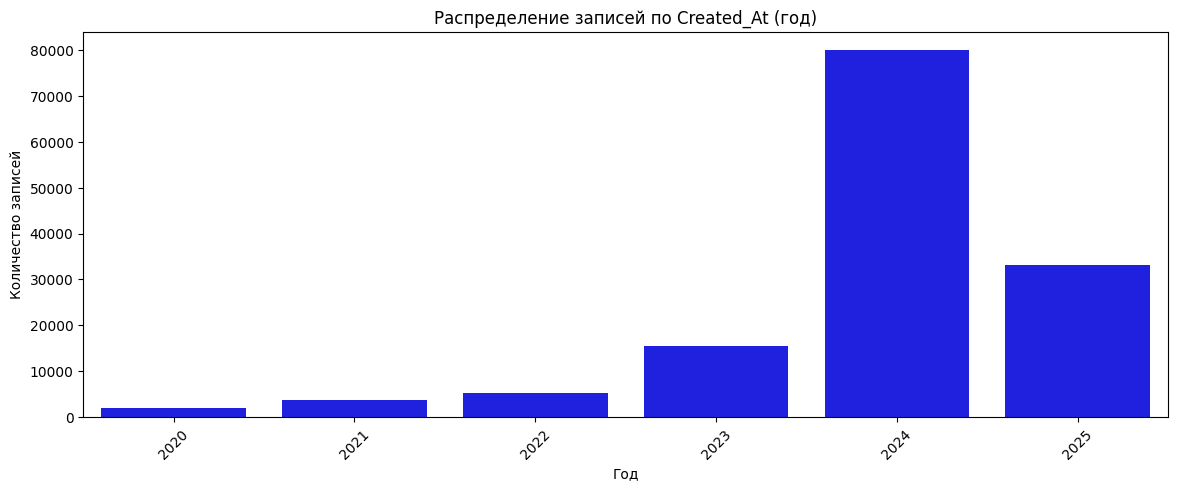

In [16]:
df_filtered['Created_Year'] = df_filtered['Created_At'].dt.to_period('Y')

year_counts = df_filtered.groupby('Created_Year').size()
plt.figure(figsize=(14, 5))
sns.barplot(x=year_counts.index.astype(str),
            y=year_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Created_At (год)")
plt.show()

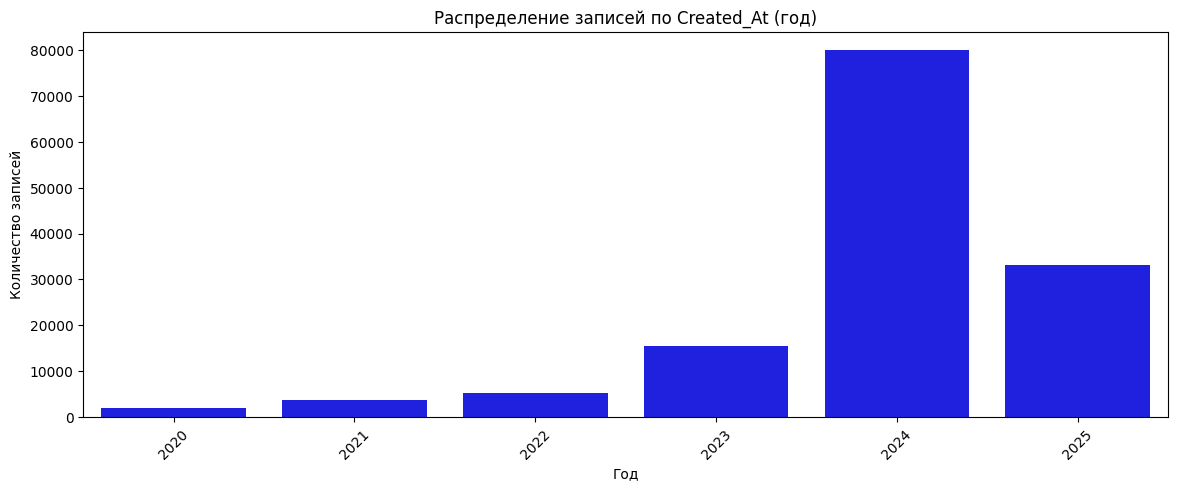

In [17]:
df_filtered['Last_Move_Year'] = df_filtered['Last_Move_At'].dt.to_period('Y')

year_month_counts = df_filtered.groupby('Last_Move_Year').size()

plt.figure(figsize=(14, 5))
sns.barplot(x=year_month_counts.index.astype(str),
            y=year_month_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Created_At (год)")
plt.show()

#### Числовые

Распределение имеет положительную асимметрию (хвост уходит вправо), поэтому применяем логарифмирование для уменьшения разброса значений и приведения данных к более нормальному виду.

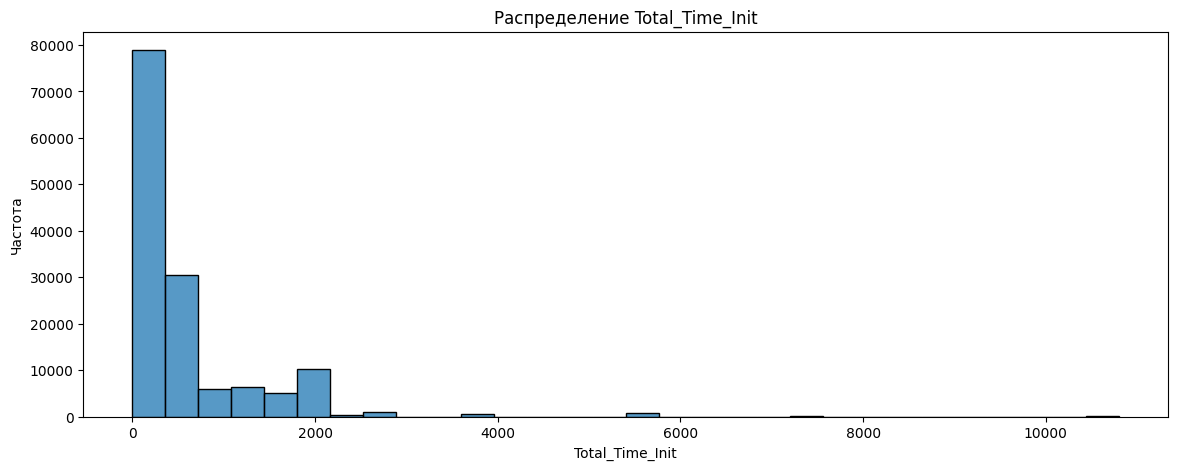

In [18]:
plt.figure(figsize=(14, 5))
sns.histplot(df_filtered['Total_Time_Init'], bins=30)
plt.title('Распределение Total_Time_Init')
plt.xlabel('Total_Time_Init')
plt.ylabel('Частота')
plt.show()

In [19]:
df_filtered['Total_Time_Init_log'] = np.log1p(df_filtered['Total_Time_Init'])

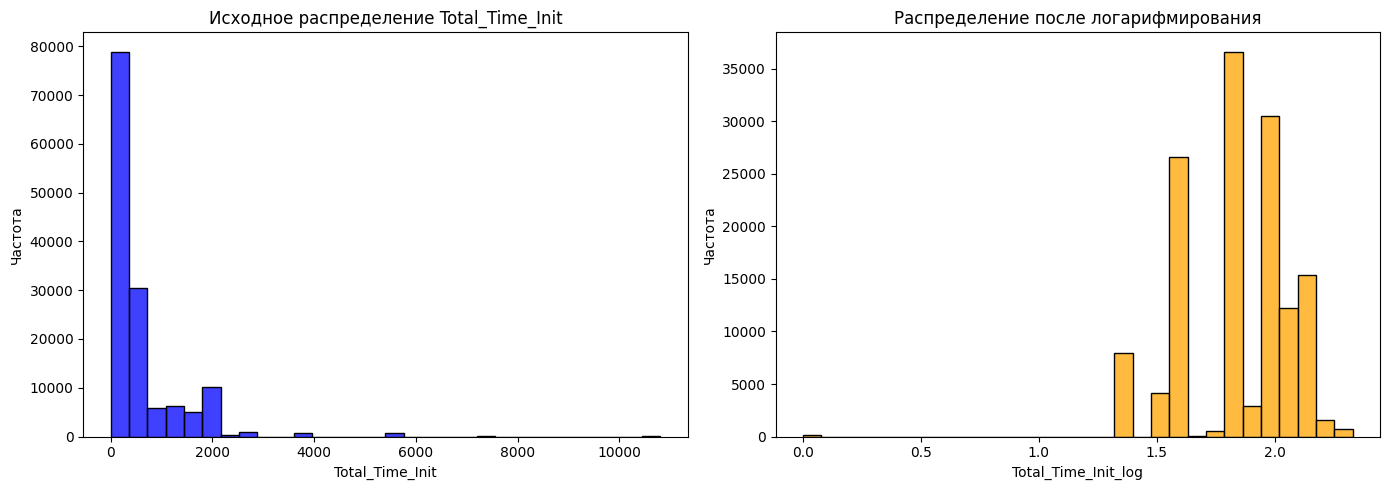

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_filtered['Total_Time_Init'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение Total_Time_Init")
ax[0].set_xlabel("Total_Time_Init")
ax[0].set_ylabel("Частота")

sns.histplot(np.log1p(
    df_filtered['Total_Time_Init_log']), bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("Total_Time_Init_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

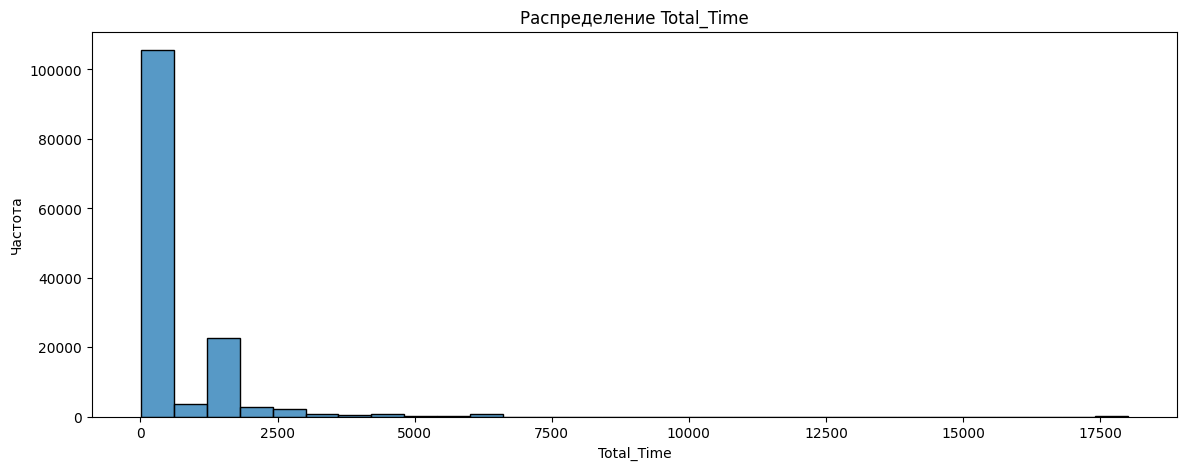

In [21]:
plt.figure(figsize=(14, 5))
sns.histplot(df_filtered['Total_Time'], bins=30)
plt.title('Распределение Total_Time')
plt.xlabel('Total_Time')
plt.ylabel('Частота')
plt.show()

In [22]:
df_filtered['Total_Time_log'] = np.log1p(df_filtered['Total_Time'])

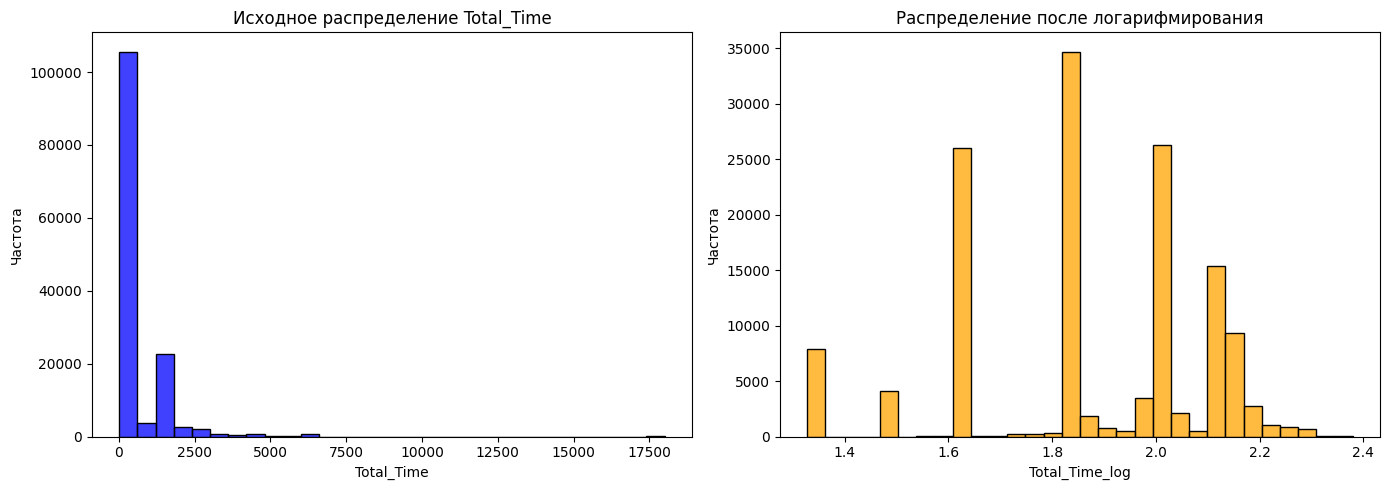

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_filtered['Total_Time'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение Total_Time")
ax[0].set_xlabel("Total_Time")
ax[0].set_ylabel("Частота")

sns.histplot(np.log1p(
    df_filtered['Total_Time_log']), bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("Total_Time_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

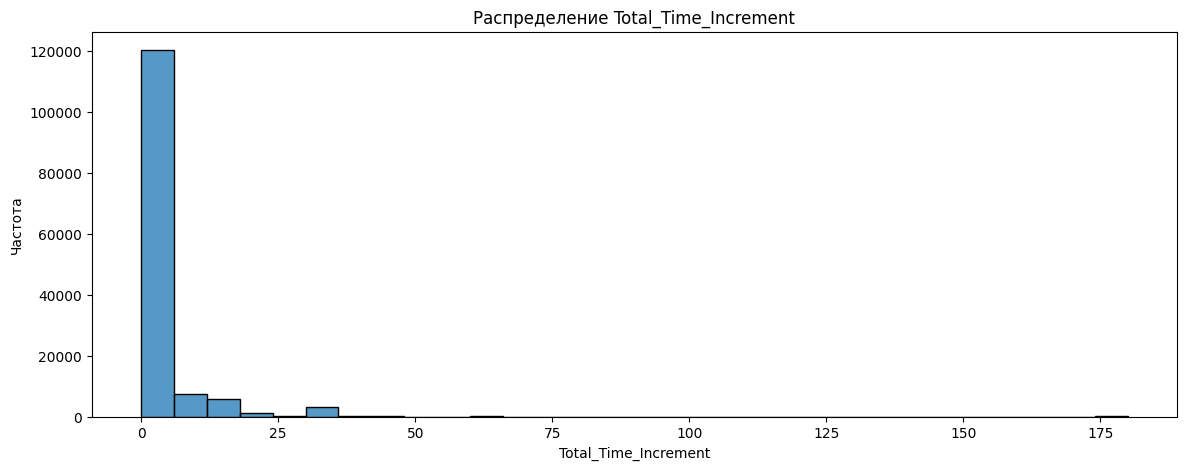

In [24]:
plt.figure(figsize=(14, 5))
sns.histplot(df_filtered['Total_Time_Increment'], bins=30)
plt.title('Распределение Total_Time_Increment')
plt.xlabel('Total_Time_Increment')
plt.ylabel('Частота')
plt.show()

In [25]:
df_filtered['Total_Time_Increment_log'] = np.log1p(
    df_filtered['Total_Time_Increment'])

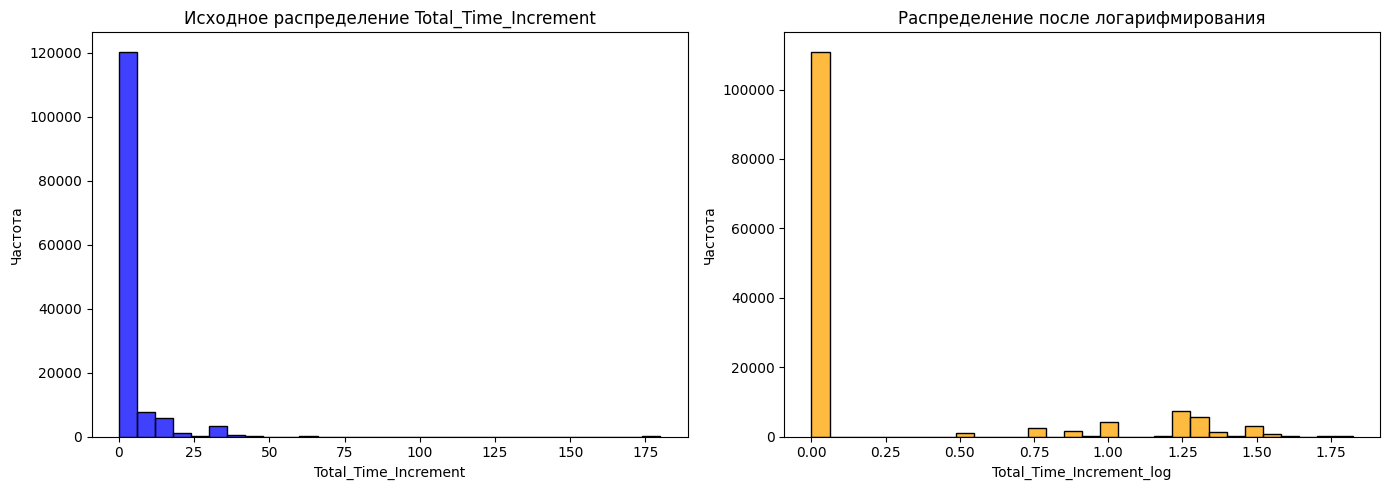

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_filtered['Total_Time_Increment'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение Total_Time_Increment")
ax[0].set_xlabel("Total_Time_Increment")
ax[0].set_ylabel("Частота")

sns.histplot(np.log1p(
    df_filtered['Total_Time_Increment_log']), bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("Total_Time_Increment_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

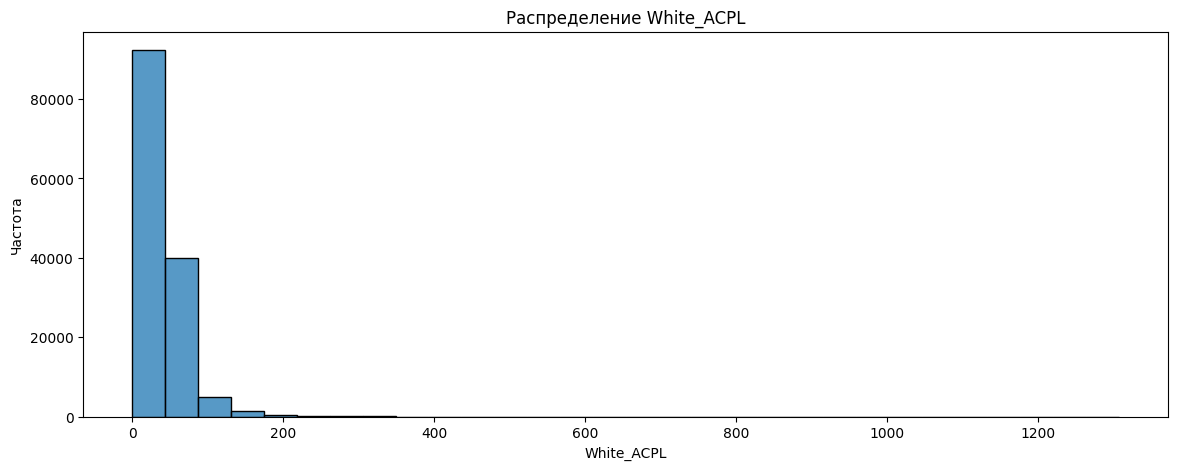

In [27]:
plt.figure(figsize=(14, 5))
sns.histplot(df_filtered['White_ACPL'], bins=30)
plt.title('Распределение White_ACPL')
plt.xlabel('White_ACPL')
plt.ylabel('Частота')
plt.show()

In [28]:
df_filtered['White_ACPL_log'] = np.log1p(df_filtered['White_ACPL'])

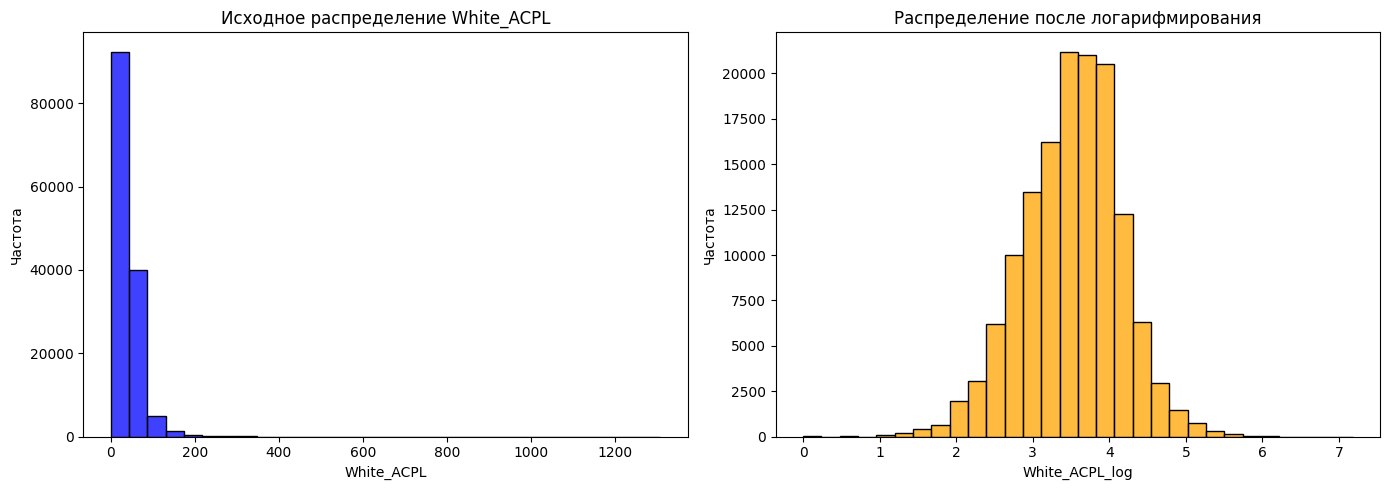

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_filtered['White_ACPL'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение White_ACPL")
ax[0].set_xlabel("White_ACPL")
ax[0].set_ylabel("Частота")

sns.histplot(
    df_filtered['White_ACPL_log'], bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("White_ACPL_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

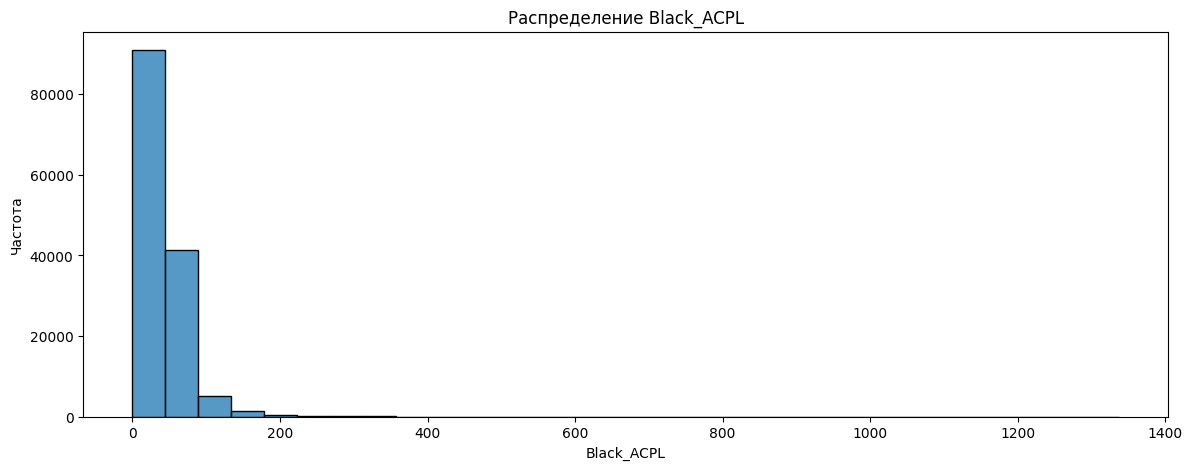

In [30]:
plt.figure(figsize=(14, 5))
sns.histplot(df_filtered['Black_ACPL'], bins=30)
plt.title('Распределение Black_ACPL')
plt.xlabel('Black_ACPL')
plt.ylabel('Частота')
plt.show()

In [31]:
df_filtered['Black_ACPL_log'] = np.log1p(df_filtered['Black_ACPL'])

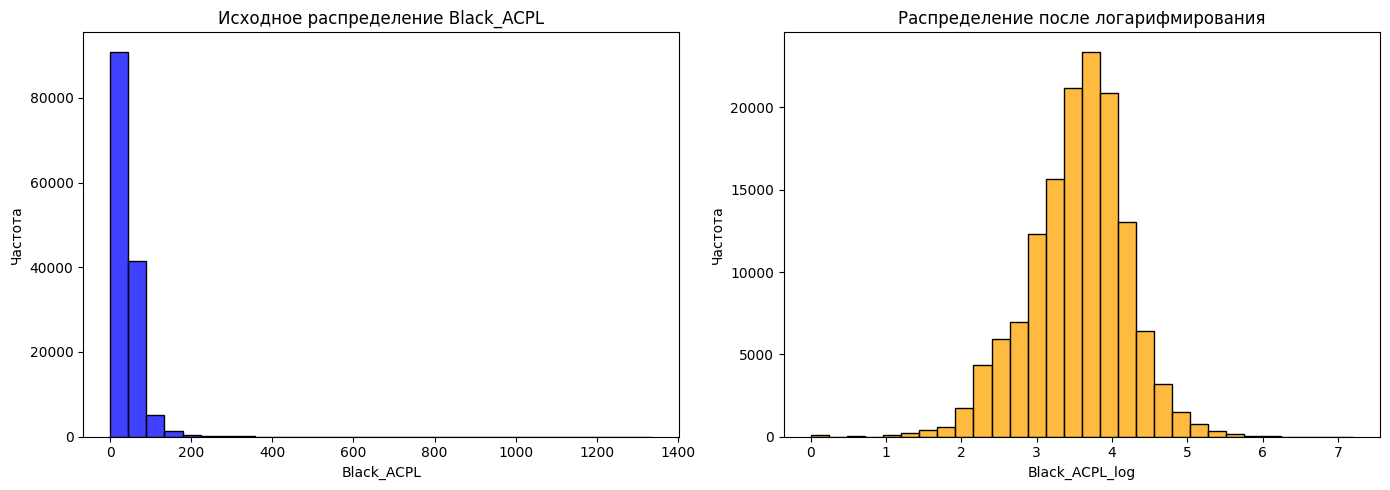

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_filtered['Black_ACPL'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение Black_ACPL")
ax[0].set_xlabel("Black_ACPL")
ax[0].set_ylabel("Частота")

sns.histplot(
    df_filtered['Black_ACPL_log'], bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("Black_ACPL_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

Посмотрим на распределение кол-ва ходов в партии

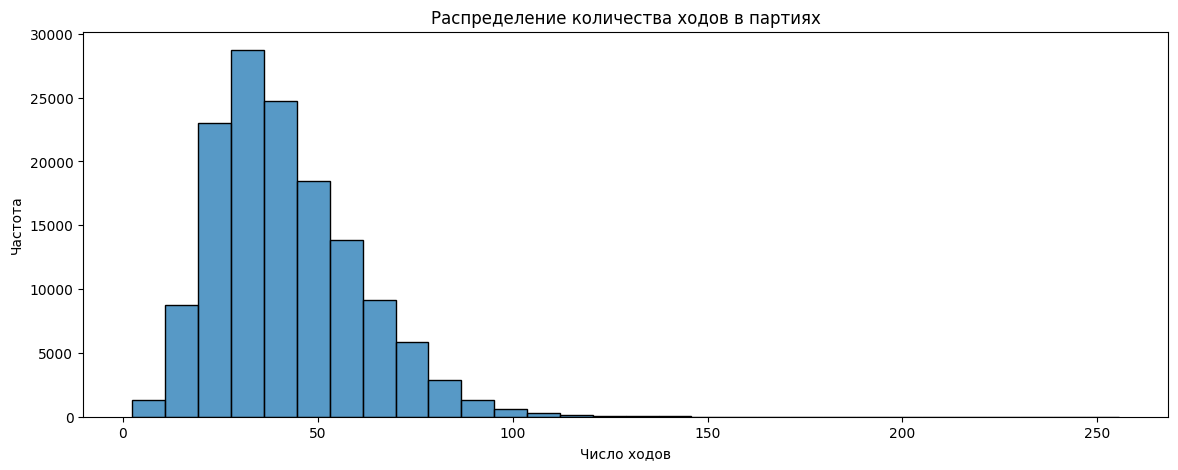

In [33]:
df_filtered["num_moves"] = df_filtered["Moves"].apply(
    lambda x: len(x.split()) / 2)

plt.figure(figsize=(14, 5))
sns.histplot(df_filtered["num_moves"], bins=30)
plt.title("Распределение количества ходов в партиях")
plt.xlabel("Число ходов")
plt.ylabel("Частота")
plt.show()

Посмотрим на описательную статистику новой переменной - кол-ва ходов

In [34]:
df_filtered["num_moves"].describe()

count    139326.000000
mean         41.891129
std          18.468605
min           2.500000
25%          28.500000
50%          38.500000
75%          53.000000
max         255.500000
Name: num_moves, dtype: float64

### Вопросы & Выводы

Какие самые популярные первые, вторые и третьи, сделанные ходы в партиях

In [35]:
df_filtered["Moves"].apply(lambda x: x.split()[:6]).value_counts()

Moves
[e4, c5, Nf3, d6, d4, cxd4]       4675
[e4, e5, Nf3, Nc6, Bb5, a6]       2500
[e4, c5, Nf3, e6, d4, cxd4]       2334
[d4, Nf6, c4, e6, Nc3, Bb4]       1987
[e4, c5, Nf3, Nc6, d4, cxd4]      1944
                                  ... 
[e3, e5, Nf3, e4, Bc4, exf3]         1
[e4, d5, Nf3, dxe4, Bc4, exf3]       1
[b3, e6, Bb2, Ne7, Qc1, d6]          1
[d3, g6, Nd2, Bg7, e3, Nf6]          1
[e4, d5, Nc3, dxe4, d4, Nf6]         1
Name: count, Length: 22011, dtype: int64

Самые популярные ходы сделаны пешками к центру доски и конями к центру доски

Посмотрим какой фигурой чаще всего делается последний ход

In [36]:
df_filtered["Moves"].apply(lambda x: "P" if x.split()[-1][0].islower() else x.split()
                  [-1][0] if x.split()[-1][0] != "O" else "Castle").value_counts()

Moves
Q         37475
R         33020
K         21209
P         18834
B         14513
N         14127
Castle      148
Name: count, dtype: int64

Чаще всего последний ход делается Ферзем или ладьей

Узнаем в какойдень недели чаще всего играют в шахматы

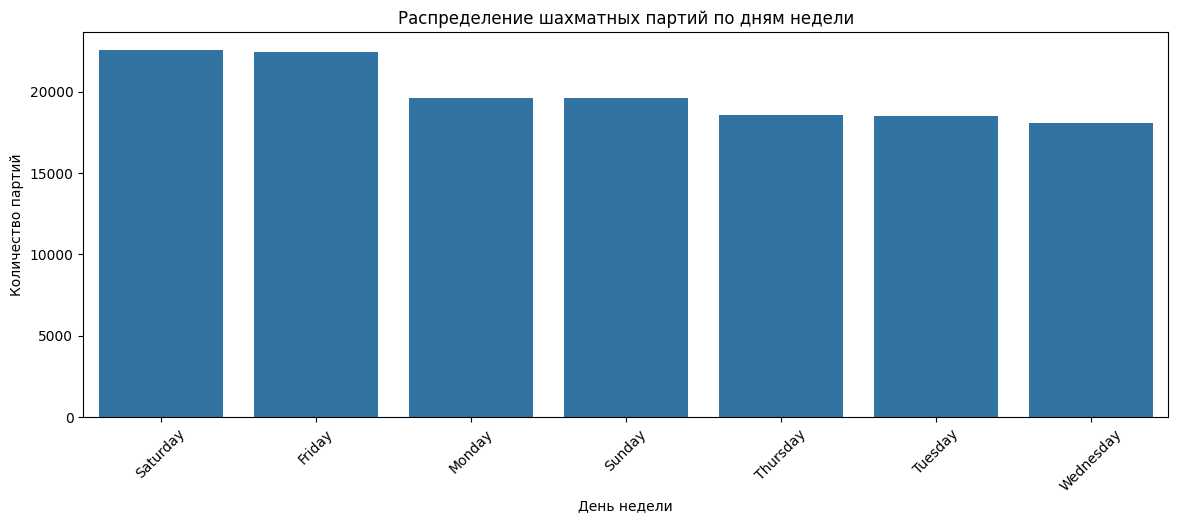

In [37]:
df_filtered["weekday"] = df_filtered["Created_At"].dt.day_name()
day_counts = df_filtered["weekday"].value_counts()

plt.figure(figsize=(14, 5))
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title("Распределение шахматных партий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество партий")
plt.xticks(rotation=45)
plt.show()

По пятницам и субботам в шахматы играют чаще всего

Узнаем в какой время суток чаще всего играют в шахматы

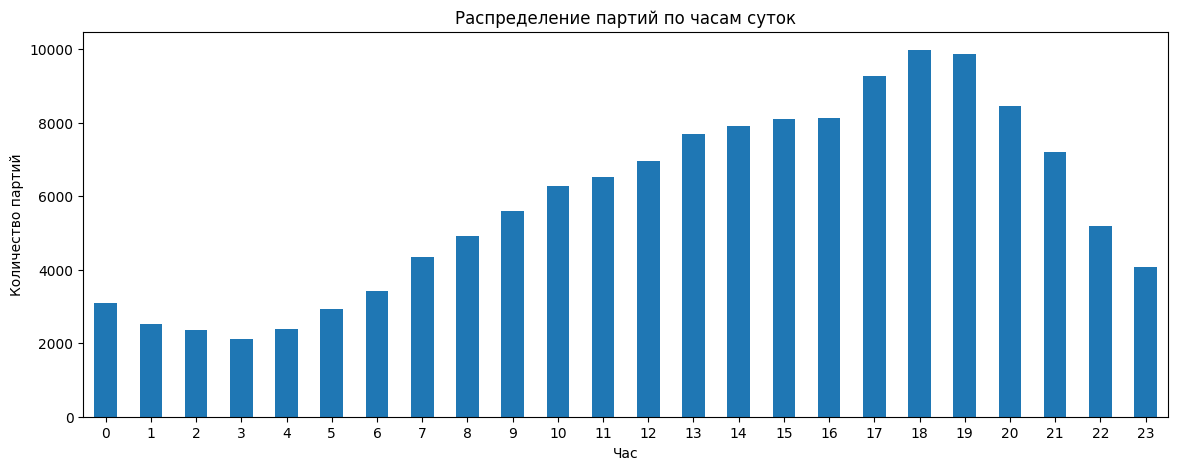

In [38]:
df_filtered["hour"] = df_filtered["Created_At"].dt.hour
df_filtered["hour"].value_counts().sort_index().plot(
    kind="bar", figsize=(14, 5))
plt.title("Распределение партий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество партий")
plt.xticks(rotation=0)
plt.show()

Чаще всего люди играют в вечернее время (с 17 до 20 UTC)